In [370]:
# Importing the required libraries to run this .ipynb file
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from xgboost import XGBClassifier

import joblib

## Loading the dataset's

### Fake News Dataset --

In [3]:
# 1st dataframe which is called fake_news_original hold's the dataset which have all the fake news data
fake_news_original = pd.read_csv(r"C:\Users\Varun\Downloads\Saurav\Outsource 360 internship\Project\Datasets\Fake-Real-News\Fake.csv")

In [4]:
# making a copy of original dataset
fake_news = fake_news_original.copy()

In [5]:
# lets take the preview of our dataset
# Top 5 rows
fake_news.head(5)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [6]:
# Bottom 5 rows
fake_news.tail(5)

title  \
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                   date  
23476  January 16, 2016  
23477  January 16, 2016  
23478  January 15, 2016  
23479  January 14, 2016  
23480  January 12, 2016

In [7]:
# sample 5 rows to be sure about the consistency of the data throughout the data as sample produce random sample's from data
fake_news.sample(5)

title  \
2268    Kellyanne Conway Makes A Fool Of Herself Tryi...   
14897  DEMOCRAT CONGRESSWOMAN Who Served Two Tours In...   
2633    Mitch McConnell VICIOUSLY Cuts Off Elizabeth ...   
7617    What Republicans Just Said About Tammy Duckwo...   
2923    Donald Trump Even Stole The Cake Design From ...   

                                                    text   subject  \
2268   On Monday, Trump propaganda minister Kellyanne...      News   
14897  Congresswoman Gabbard also criticizes Hillary ...  politics   
2633   Another girl hurt a Republican s feelings. Thi...      News   
7617   If you had any doubt in your mind that Republi...      News   
2923   At this point, it s fair to ask,  What is Dona...      News   

                   date  
2268      March 6, 2017  
14897      Nov 23, 2015  
2633   February 7, 2017  
7617      March 8, 2016  
2923   January 21, 2017

- Looking at the preview of the dataset we got to know that our dataset consist of four columns{title,text,subject,date}.
- And our data remains consistent throughout.

In [8]:
# lets take a look-out the data types of each column 
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


- All the columns of the dataset apart from date column is holding the correct data-type. Therefore, change the Dtype of date column

In [9]:
# Converting the date column into actual date Dtype column from object Dtype
fake_news["date"] = pd.to_datetime(fake_news["date"], errors='coerce', dayfirst=True, format='mixed')

In [10]:
# Number of rows where date was not parsed
print(fake_news['date'].isna().sum(), "dates could not be parsed.")

10 dates could not be parsed.


In [11]:
# Get indexes where date parsing failed
invalid_indexes = fake_news[fake_news['date'].isna()].index.tolist()
print("Problematic Row Indexes:", invalid_indexes)

Problematic Row Indexes: [9358, 15507, 15508, 15839, 15840, 17432, 17433, 18933, 21869, 21870]


In [12]:
# example that date column on the problematic rows were not holding date values in actual they were holding links:-
fake_news_original.iloc[9358]

title      https://100percentfedup.com/served-roy-moore-v...
text       https://100percentfedup.com/served-roy-moore-v...
subject                                             politics
date       https://100percentfedup.com/served-roy-moore-v...
Name: 9358, dtype: object

In [13]:
# Shape of dataset before droping the date columns
fake_news.shape

(23481, 4)

In [14]:
# Droping the rows date rows which holds link [Drop rows where 'date' is NaT]
fake_news = fake_news.dropna(subset=['date'])

In [15]:
# Shape of dataset after droping values
fake_news.shape  
# This clearly shows that we have dropeed 10 rows {which were problematic dates} and now our date's column is clean and in datetime dtype

(23471, 4)

In [16]:
fake_news.iloc[9358]

title      LOL! #FakeNews CNN’s April Ryan EMBARRASSES He...
text       CNN political analyst just spent her Thanksgiv...
subject                                             politics
date                                     2017-11-25 00:00:00
Name: 9359, dtype: object

In [17]:
# changed Dtype of date column
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23471 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23471 non-null  object        
 1   text     23471 non-null  object        
 2   subject  23471 non-null  object        
 3   date     23471 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 916.8+ KB


- Reasons for date rows failed to parsed was that, date column had some error's in them. For instance, the mentioned index number of the problematic
  rows. Here the date column was holding link's of news as shown in the above example in fake_news.iloc[9358].Since the number is very less [10]
  we can drop them.

In [18]:
# Creating a new column in our dataset [label] which will hold value {fake} bcz it is fake dataset and going forward we will be combining this 
# with true label dataset and training model on top of it. So, let create a new feature for our dataset. 

In [19]:
fake_news["label"] = "fake" 

In [20]:
# New shape of our dataset
fake_news.shape

(23471, 5)

In [21]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23471 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23471 non-null  object        
 1   text     23471 non-null  object        
 2   subject  23471 non-null  object        
 3   date     23471 non-null  datetime64[ns]
 4   label    23471 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.1+ MB


### True News Dataset -- 

In [22]:
# 2nd dataframe which is called true_news_original hold's the dataset which have all the true news data
true_news_original = pd.read_csv(r"C:\Users\Varun\Downloads\Saurav\Outsource 360 internship\Project\Datasets\Fake-Real-News\True.csv")

In [23]:
# making a copy of original dataset
true_news = true_news_original.copy()

In [24]:
# lets take the preview of our dataset
# Top 5 rows
true_news.head(5)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [25]:
# Bottom 5 rows
true_news.tail(5)

title  \
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
21412  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
21413  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
21414  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
21415  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
21416  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                   date  
21412  August 22, 2017   
21413  August 22, 2017   
21414  August 22, 2017   
21415  August 22, 2017   
21416  August 22, 2017

In [26]:
# sample 5 rows to be sure about the consistency of the data throughout the data as sample produce random sample's from data
true_news.sample(5)

title  \
11293  Myanmar says U.S. sanctions against general ba...   
14207  Australia defends alternative accommodation fo...   
17537  Activists urge Apple to drop apps that play up...   
15899  Liberia's Supreme Court halts election prepara...   
8430   Hackers targeted Trump campaign, Republican Pa...   

                                                    text       subject  \
11293  (Reuters) - Myanmar  feels sad  over a U.S. de...     worldnews   
14207  SYDNEY/GENEVA (Reuters) - Australia s foreign ...     worldnews   
17537  MANILA (Reuters) - A group of civil society or...     worldnews   
15899  MONROVIA (Reuters) - Liberia s Supreme Court h...     worldnews   
8430   (Reuters) - Hackers targeted the computer syst...  politicsNews   

                     date  
11293  December 27, 2017   
14207  November 22, 2017   
17537   October 13, 2017   
15899   November 1, 2017   
8430     August 18, 2016

In [27]:
# lets take a look-out the data types of each column 
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


- As of now our true dataset is following the fake_news dataset in terms of number of column's and name of the columns as well.
- And the Dtype is also the same (of raw data). Therefore, change the Dtype of date column

In [28]:
# Converting the date column into actual date Dtype column from object Dtype
true_news["date"] = pd.to_datetime(true_news["date"], errors='coerce', dayfirst=True, format='mixed')

In [29]:
# Number of rows where date was not parsed
print(fake_news['date'].isna().sum(), "dates could not be parsed.")

0 dates could not be parsed.


In [30]:
# Number of na in date column
true_news.date.isna().sum()

0

In [31]:
# In this dataset all the date's value where right.Therefore no need to alter the dataset.So let's check the shape of our dataset --
true_news.shape

(21417, 4)

In [32]:
# changed Dtype of date column
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 669.4+ KB


In [33]:
# Creating a new column label as we did for the fake_news dataset 
true_news["label"] = "true" 

In [34]:
# New shape of our dataset
true_news.shape

(21417, 5)

In [35]:
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
 4   label    21417 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 836.7+ KB


## Combining the Dataset's --
* Here we will be combining the dataset's [true_news & fake_news] to form a new dataset [News].

In [36]:
# preview of true news dataset --
true_news.sample(3)

title  \
12852  Moscow says Russian Olympic ban designed to so...   
18572  There was no independence referendum in Catalo...   
15975  Asylum seekers refuse to leave Papua New Guine...   

                                                    text    subject  \
12852  MOSCOW (Reuters) - Russian Prime Minister Dmit...  worldnews   
18572  MADRID (Reuters) - Spain s northeastern region...  worldnews   
15975  SYDNEY (Reuters) - Hundreds of asylum seekers ...  worldnews   

            date label  
12852 2017-12-07  true  
18572 2017-10-01  true  
15975 2017-10-31  true

In [37]:
# preview of fake news dataset --
fake_news.sample(3)

title  \
8759    Terrifying: Watch Donald Trump Turn These Ado...   
10191  HA-HA! RETIRED MARINE TROLLS LIBERAL NEW YORKE...   
4398    WATCH: Van Jones EVISCERATES Supporter Who Th...   

                                                    text   subject       date  \
8759   Being a xenophobic bigot and a confirmed fasci...      News 2016-01-14   
10191  It s always a win-win when you can find a hobb...  politics 2017-08-09   
4398   Donald Trump has been positioning himself as a...      News 2016-10-02   

      label  
8759   fake  
10191  fake  
4398   fake

In [38]:
# Craeting a new dataset {news} by combing true and fake news dataset's
news = pd.concat([true_news,fake_news],ignore_index = True)

- Reason for using ignore_index is to reset index as by default it is False and result in repetition of inedx number.Hence I used
  ignore_index = True which results in normal increasing index no's and no repetition.

In [39]:
# Preview of our new combined dataset (top 5)
news.head(5)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject       date  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews 2017-12-31   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews 2017-12-29   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews 2017-12-31   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews 2017-12-30   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews 2017-12-29   

  label  
0  true  
1  true  
2  true  
3  true  
4  true

In [40]:
# Bottom 5 
news.tail(5)

title  \
44883  McPain: John McCain Furious That Iran Treated ...   
44884  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44885  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44886  How to Blow $700 Million: Al Jazeera America F...   
44887  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
44883  21st Century Wire says As 21WIRE reported earl...  Middle-east   
44884  21st Century Wire says It s a familiar theme. ...  Middle-east   
44885  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
44886  21st Century Wire says Al Jazeera America will...  Middle-east   
44887  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

            date label  
44883 2016-01-16  fake  
44884 2016-01-16  fake  
44885 2016-01-15  fake  
44886 2016-01-14  fake  
44887 2016-01-12  fake

- Because,of our concatination the top rows are of all true news and bottom rows are all fake news and while going ahead in model building
  it can cause biasness in our model so it is better we shuffle our dataset here only and then move forward.

In [41]:
# Shuffling the dataset to introduce randomness in our dataset
news = news.sample(frac=1, random_state=42).reset_index(drop=True)

# sample(frac = 1)         : Samples 100% of the data in a random order (shuffles all rows).
# random_state = 42        : Ensures reproducibility of the shuffle.
# reset_index(drop = True) : Resets index after shuffling (drops the old index).

In [42]:
news.head(5)

title  \
0   Suicide attack targets area southeast of Baghdad   
1  FLASHBACK: WATCH TED CRUZ Promise To Support D...   
2  Boris Johnson gives PM May advice on Brexit wh...   
3  India struggles to rein in border flows of cat...   
4  In speech, Trump tries to turn from divisive t...   

                                                text       subject       date  \
0  BAGHDAD (Reuters) - Two attackers shot several...     worldnews 2017-11-27   
1      Yes, he did promise to support Donald Trump:       politics 2016-07-21   
2  MANCHESTER, England (Reuters) - British Foreig...     worldnews 2017-10-03   
3  NEW DELHI (Reuters) - Stopping Rohingya refuge...     worldnews 2017-10-05   
4  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews 2017-03-01   

  label  
0  true  
1  fake  
2  true  
3  true  
4  true

- Saving our new dataset in our local machine --

In [43]:
# Since our new dataset is formed let's save it in our local machine --
news.to_csv('News.csv', index = False)

In [44]:
# let's see the basic info (dtype) of new dataset 
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44888 entries, 0 to 44887
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    44888 non-null  object        
 1   text     44888 non-null  object        
 2   subject  44888 non-null  object        
 3   date     44888 non-null  datetime64[ns]
 4   label    44888 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.7+ MB


In [45]:
# Name of the columns
news.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [46]:
# shape of new dataset
news.shape

(44888, 5)

In [47]:
# Value count to see the number of fake news and true news in our dataset
news["label"].value_counts()

label
fake    23471
true    21417
Name: count, dtype: int64

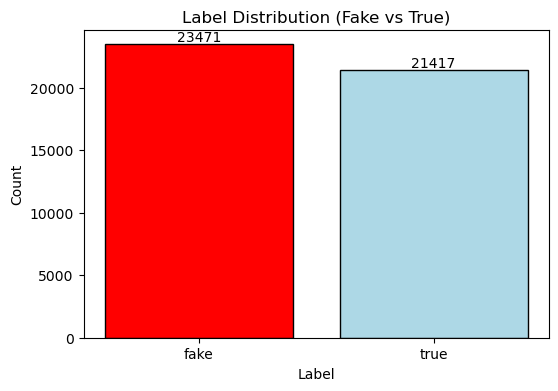

In [48]:
# Plotting the label count result for better visulaization
# Get label counts
label_counts = news['label'].value_counts()

# Define colors for each label (assuming 'fake' and 'true' labels)
colors = ['red' if label == 'fake' else 'lightblue' for label in label_counts.index]

# Plot bar chart
plt.figure(figsize=(6,4))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution (Fake vs True)')
plt.show()

In [49]:
# Percentage of label values in our datset's
print("Fake news percentage in our dataset",np.round((label_counts[0] / len(news) * 100),1))
print("True news percentage in our dataset",np.round((label_counts[1] / len(news) * 100),1))

Fake news percentage in our dataset 52.3
True news percentage in our dataset 47.7


- Since the ratio between classes is mildly imblance almost (52 vs 48).
- For machine learning models, such a small difference typically won’t cause serious bias.
- Most ML algorithms handle this level of imbalance naturally. Also we will use stratify while train test split to avoid any biasness this distributuion
  is very normal.

In [50]:
# This provide us the basic info about our data [used include = object] to extarct info of non-numeric data
news.describe(include = 'object')

title   text  \
count                                               44888  44888   
unique                                              38723  38640   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject  label  
count          44888  44888  
unique             8      2  
top     politicsNews   fake  
freq           11272  23471

**Finding About our Dataset using describe func -**
-
- We have no na value in any of the coulmns.
- We have 38,723 unique titles.The most repeated title appears 14 times. [Factbox: Trump fills top jobs for his administratio]
- There are 38,640 unique text bodies, but some duplicates.One empty or repetitive article appears 627 times, might be missing or placeholder text.
- There are 8 unique subjects (categories like politicsNews, worldNews, etc.). PoliticsNews dominates with 11,272 articles (~25% of data).
- Dataset is almost balanced: 23,471 Fake (52.3%), 21,417 Real (47.7%).

In [51]:
# Most repeated title of the news dataset
title_counts = news['title'].value_counts()

# Display the top 10 most repeated titles
print(title_counts.head(10))

title
Factbox: Trump fills top jobs for his administration                                                     14
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                          8
Factbox: Contenders for senior jobs in Trump's administration                                             8
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                 6
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead     6
Highlights: The Trump presidency on March 31 at 6:19 p.m. EDT                                             5
Factbox: Contenders, picks for key jobs in Trump's administration                                         5
Highlights: The Trump presidency on April 21 at 6:12 p.m. EDT/2212 GMT                                    5
FORMER FBI ASST DIRECTOR: “Jim Comey ‘Danced With The Devil’…I’m Glad He’s Gone” [VIDEO]                  4
Timeline: Zika's origi

In [52]:
# As our describe that our data can have some duplicate's specially in text column so let's look for that 
news.duplicated().sum() # So we have 209 rows that hold duplicate values

209

In [53]:
# let's have a look at the duplicates values in our data 
news[news.duplicated()].head(10)

title  \
2704  Lebanon's interior minister accuses Uber of no...   
4568  Venezuela may ban main opposition parties from...   
5095    Saudi king receives Palestinian president Abbas   
5099  Jailed British-Iranian charity worker received...   
5593  Indonesian police warn Islamists against raids...   
5706  Republicans unveil tax cut bill, but the hard ...   
6098  Vietnam police arrest ex-politburo member over...   
6681  France unveils labor reforms in first step to ...   
6855  Kidnapped aid workers in South Sudan released:...   
7166  Sessions confirmed as U.S. attorney general af...   

                                                   text       subject  \
2704  BEIRUT (Reuters) - Lebanon s interior minister...     worldnews   
4568  CARACAS (Reuters) - Venezuela s pro-government...     worldnews   
5095  DUBAI (Reuters) - Saudi Arabia s King Salman r...     worldnews   
5099  BEIRUT (Reuters) - A British-Iranian charity w...     worldnews   
5593  JAKARTA (Reuters) - Indonesian police appealed...     worldnews   
5706  WASHINGTON (Reuters) - U.S. House of Represent...  politicsNews   
6098  HANOI (Reuters) - Vietnamese police on Friday ...     worldnews   
6681  PARIS (Reuters) - French President Emmanuel Ma...     worldnews   
6855  JUBA (Reuters) - Six aid workers kidnapped by ...     worldnews   
7166  WASHINGTON (Reuters) - A bitterly divided U.S....  politicsNews   

           date label  
2704 2017-12-21  true  
4568 2017-12-21  true  
5095 2017-12-20  true  
5099 2017-10-17  true  
5593 2017-12-21  true  
5706 2017-11-02  true  
6098 2017-12-08  true  
6681 2017-08-31  true  
6855 2017-12-20  true  
7166 2017-02-09  true

In [54]:
news[news.duplicated()]["label"].value_counts()

label
true    206
fake      3
Name: count, dtype: int64

- After carefully observing the data in Excel, i came to the conclusion that we have Soft Duplicates (Same label with minor metadata differences in
  features like date and text) and i will not be dropping them.

**Reasons**
-
  
- A) Impact is minimal if:
        Dataset is large. which is true is our case
        Duplicates form a small percentage (like our case: 209 rows in 45,000 rows, that is negligible).
        For models like Logistic Regression, SVM, small soft duplicates barely hurt performance.
        For tree-based models (Random Forest, XGBoost), they have even less effect on bias.
- B) Out of 45,000 rows, this is < 0.5% of our data.
        It’s safe to keep them.
        No major impact on model generalization.

- C) Soft duplicates (206 True, 3 Fake) were retained to reflect real-world news repetition scenarios. Their minor proportion (~0.5%) is not                 significant enough to introduce model bias.

## EDA

In [55]:
# preview of our data 
news.head(5)

title  \
0   Suicide attack targets area southeast of Baghdad   
1  FLASHBACK: WATCH TED CRUZ Promise To Support D...   
2  Boris Johnson gives PM May advice on Brexit wh...   
3  India struggles to rein in border flows of cat...   
4  In speech, Trump tries to turn from divisive t...   

                                                text       subject       date  \
0  BAGHDAD (Reuters) - Two attackers shot several...     worldnews 2017-11-27   
1      Yes, he did promise to support Donald Trump:       politics 2016-07-21   
2  MANCHESTER, England (Reuters) - British Foreig...     worldnews 2017-10-03   
3  NEW DELHI (Reuters) - Stopping Rohingya refuge...     worldnews 2017-10-05   
4  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews 2017-03-01   

  label  
0  true  
1  fake  
2  true  
3  true  
4  true

### Subject column

In [56]:
# Number of categories in subject column
news["subject"].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6836
left-news           4456
Government News     1568
US_News              783
Middle-east          778
Name: count, dtype: int64

In [57]:
# Visualization for the above data (subject categories)

# Data
subjects = ['politicsNews', 'worldnews', 'News', 'politics', 'left-news', 'Government News', 'US_News', 'Middle-east']
counts = [11272, 10145, 9050, 6836, 4456, 1568, 783, 778]

# Create Bar Plot with Custom Colors and Borders

fig = go.Figure(data=[go.Bar(
                             x = subjects,
                             y = counts,
                             marker = dict(
                                        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],
                                        line=dict(color='black', width=2)  # Border around bars
                                           ))])

# Layout Customization
fig.update_layout(
    title = "Subject Distribution of News Articles with Trend Line",
    xaxis_title = "Subjects",
    yaxis_title = "Number of Articles",
    yaxis = dict(
                dtick      = 2000,  # Y-axis step size of 2000
                tickformat = ',d'),  # Comma-separated thousands format
    
    template = "plotly_white",
    font     = dict(size = 14),
    bargap   = 0.3,
    plot_bgcolor = "rgba(0,0,0,0)",
    title_font_size = 20,
    width = 1000, 
    height = 600 
)

fig.show()

- Most of the news in our data is subjected as Poltics news and least as Middle-east.However, we can see that there are 2 categories which are quite
  similar [politicsNews & politics]. Both of these categories are same so, lets merge them as one [politics].

In [58]:
# Making a copy of news data as news01 to avoid the unforseen circumstances that can be caused by merging these 2 categories
news01 = news.copy()

In [59]:
# Replace 'politics' with 'politicsNews' in 'subject' column
news01["subject"] = news01["subject"].replace(to_replace = "politicsNews",value = "politics")

In [60]:
# Number of categories in subject column
news01["subject"].value_counts()

subject
politics           18108
worldnews          10145
News                9050
left-news           4456
Government News     1568
US_News              783
Middle-east          778
Name: count, dtype: int64

In [61]:
# Visualization for the above data (subject categories)

# Data
subjects = ['worldnews', 'News', 'politics', 'left-news', 'Government News', 'US_News', 'Middle-east']
counts = [10145, 9050, 18108, 4456, 1568, 783, 778]

# Create Bar Plot with Custom Colors and Borders

fig = go.Figure(data=[go.Bar(
                             x = subjects,
                             y = counts,
                             marker = dict(
                                        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],
                                        line=dict(color='black', width=2)  # Border around bars
                                           ))])

# Layout Customization
fig.update_layout(
    title = "Subject Distribution of News Articles with Trend Line",
    xaxis_title = "Subjects",
    yaxis_title = "Number of Articles",
    yaxis = dict(
                dtick      = 2000,  # Y-axis step size of 2000
                tickformat = ',d'),  # Comma-separated thousands format
    
    template = "plotly_white",
    font     = dict(size = 14),
    bargap   = 0.3,
    plot_bgcolor = "rgba(0,0,0,0)",
    title_font_size = 20,
    width = 1000, 
    height = 600 
)

fig.show()

- This is the correct visulaization of our data on the basis of the subject of the news.
- Most published news is still Politics however after combining [politics and politicsNews] the number rose to 18000 from 12000 {increase of almost 67%}.
- And US_news count is still least as well.But we have a lot of news related to US in other categories as well so it's safe to assume that Middle-east
  realated news is least in our data.

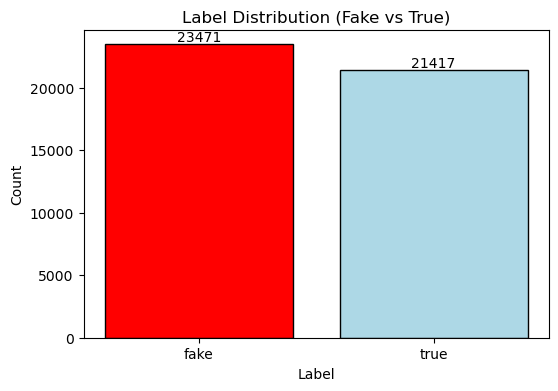

In [62]:
# we have already seen the data distribution according to label (True VS Fake)
# Plotting the label count result for better visulaization
# Get label counts
label_counts = news['label'].value_counts()

# Define colors for each label (assuming 'fake' and 'true' labels)
colors = ['red' if label == 'fake' else 'lightblue' for label in label_counts.index]

# Plot bar chart
plt.figure(figsize=(6,4))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution (Fake vs True)')
plt.show()

- Let's take this one step ahead as we will see number of fake and true news in each category to see which category publish most fake and true news.

In [63]:
# grouping subject on the basis of label of news i.e fake and true
fake_subject = news01[news01["label"] == "fake"].groupby("subject").size()
true_subject = news01[news01["label"] == "true"].groupby("subject").size()

In [64]:
fake_subject

subject
Government News    1568
Middle-east         778
News               9050
US_News             783
left-news          4456
politics           6836
dtype: int64

In [65]:
true_subject

subject
politics     11272
worldnews    10145
dtype: int64

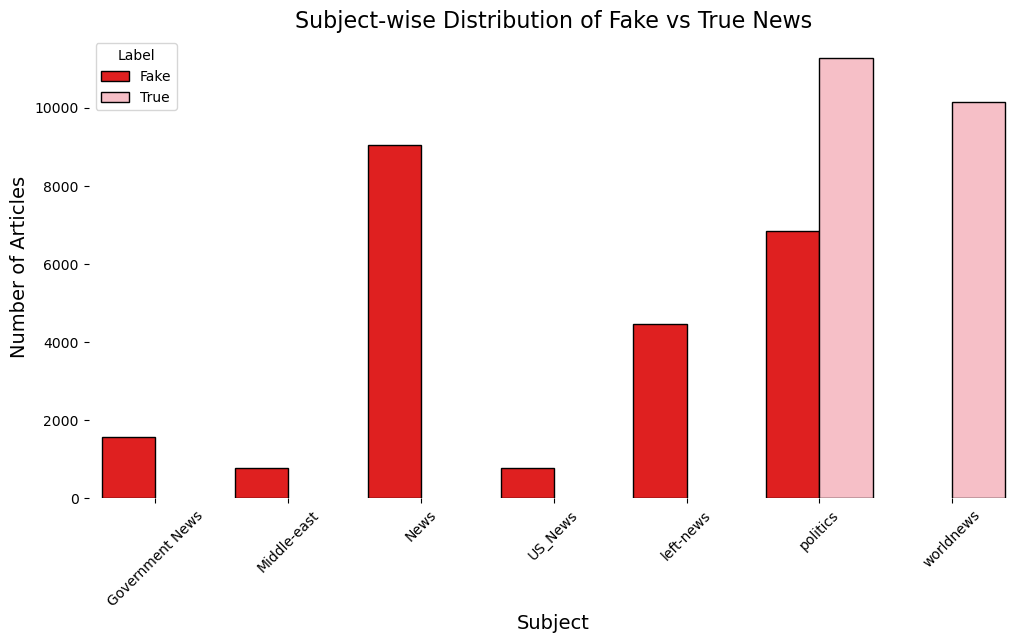

In [66]:
# Prepare Data
fake_subject = news01[news01["label"] == "fake"].groupby("subject").size().reset_index(name="count")
fake_subject["label"] = "Fake"

true_subject = news01[news01["label"] == "true"].groupby("subject").size().reset_index(name="count")
true_subject["label"] = "True"

# Combine both
subject_data = pd.concat([fake_subject, true_subject])

# Custom Color Palette
custom_palette = {"Fake": "red", "True": "lightpink"}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=subject_data,
    x="subject",
    y="count",
    hue="label",
    palette=custom_palette,
    edgecolor="black"  # Border outline for bars
)

# Remove Grid Lines
sns.despine(left=True, bottom=True)

# Labels and Title
plt.title("Subject-wise Distribution of Fake vs True News", fontsize=16)
plt.xlabel("Subject", fontsize=14)
plt.ylabel("Number of Articles", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Label")

plt.show()

- We can clearly see that apart from politics and and worldnews and no subject published true news in our data.
- And we merge the politics and politicsNews catregory and we have exactly 6836 fake news which is equal to the number of values in politics category.
  Which means that the politics category were holding all the fake news so we should not have merged them.So let's undo that.
- Going back to using **news** data inplace of **news01** [copy that contain the merged categories].

In [67]:
# This is the correct distribution 
news["subject"].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6836
left-news           4456
Government News     1568
US_News              783
Middle-east          778
Name: count, dtype: int64

In [68]:
# Data according to news dataset to make visulaization on basis of fake and true label
fake_subject = news[news["label"] == "fake"].groupby("subject").size().reset_index(name="count")
fake_subject["label"] = "Fake"

true_subject = news[news["label"] == "true"].groupby("subject").size().reset_index(name="count")
true_subject["label"] = "True"

In [69]:
fake_subject

subject  count label
0  Government News   1568  Fake
1      Middle-east    778  Fake
2             News   9050  Fake
3          US_News    783  Fake
4        left-news   4456  Fake
5         politics   6836  Fake

In [70]:
true_subject

subject  count label
0  politicsNews  11272  True
1     worldnews  10145  True

In [71]:
# Extract labels and values dynamically
labels = fake_subject["subject"].tolist()
values = fake_subject["count"].tolist()

# Gradient Blue Colors (auto match to number of subjects)
blue_gradient = ["#cce5ff", "#99ccff", "#66b2ff", "#3399ff", "#007fff", "#004c99"][:len(labels)]

# Create Interactive Pie Chart
fig = go.Figure(data=[go.Pie(
    labels = labels,
    values = values,
    textinfo = "percent+label",
    insidetextfont = dict(color = "white", size = 16, family = "Arial Black"),  # Bold White %
    marker = dict(colors = blue_gradient, line = dict(color = "black", width = 1))  # Gradient Fill + Borders
)])

# Layout Settings
fig.update_layout(
    title = "Distribution of Fake News by Subject",
    title_font_size = 20,
    showlegend = False,
    width=800,   # Increase width
    height=700,  # Increase height
)

fig.show()

- Major Contributor of fake news is News category and at 2nd place we have politics category.

In [72]:
# Extract labels and values dynamically
labels = true_subject["subject"].tolist()
values = true_subject["count"].tolist()

# Gradient Blue Colors (auto match to number of subjects)
blue_gradient = ["#cce5ff", "#99ccff"][:len(labels)]

# Create Interactive Pie Chart
fig = go.Figure(data=[go.Pie(
    labels = labels,
    values = values,
    textinfo = "percent+label",
    insidetextfont = dict(color = "white", size = 16, family = "Arial Black"),  # Bold White %
    marker = dict(colors = blue_gradient, line = dict(color = "black", width = 1))  # Gradient Fill + Borders
)])

# Layout Settings
fig.update_layout(
    title = "Distribution of Real News by Subject",
    title_font_size = 20,
    showlegend = False,
    width  = 800,   # Increase width
    height = 700,  # Increase height
)

fig.show()

- PoliticsNews category publish the most true news followed by worldnews.

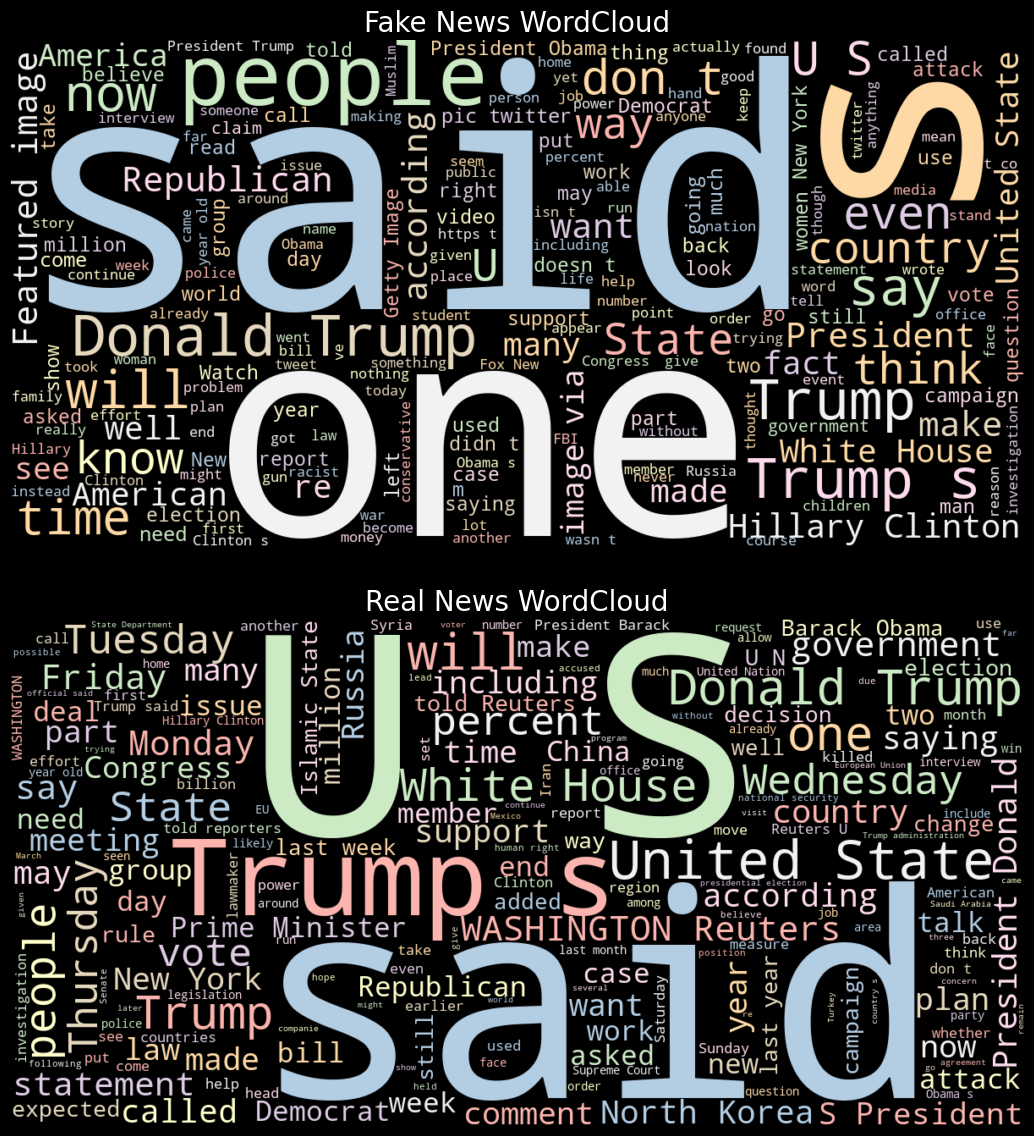

In [73]:
# Combine all text for Fake and Real news
text_data = {
    "Fake": " ".join(news.loc[news["label"] == "fake", "text"].dropna()),
    "Real": " ".join(news.loc[news["label"] == "true", "text"].dropna())
}

# Create Figure with Black Background
plt.figure(figsize=(14, 12), facecolor="black")

# Plot WordClouds Vertically
for i, (label, text) in enumerate(text_data.items(), 1):
    plt.subplot(2, 1, i)
    wordcloud = WordCloud(width=1200, height=600, background_color="black", colormap="Pastel1").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{label} News WordCloud", fontsize=20, color="white")

plt.tight_layout(pad=3.0)
plt.show()

**Common High-Frequency Words (Both Fake & Real) :**

* said, one, U.S, Trump, State, White House, President.These are common in journalistic reporting.Indicates quotes and statements are central to          both fake and real news narratives.


**Fake News Specific Observations :**

1) Words like people, Clinton, Obama, fact, Hillary, Fox, call, think, attack, left
2) Fake news seems to emphasize personal opinions, emotions, and sensational claims.
3) Buzzwords like “fact”, “think”, “call”, “attack” suggest fake articles often use persuasive or provocative language.
4) Mentions of Fox, Clinton, Obama, Hillary suggest a focus on political figures, potentially targeting polarizing topics.

**Real News Specific Observations :**

1) Words like percent, United, Tuesday, Wednesday, Thursday, Reuters, meeting, North Korea, government, decision
2) Real news has a more formal, factual reporting tone.
3) Usage of dates, percentages, and sources like Reuters indicates structured reporting style.
4) Focus on government actions, international affairs (North Korea).
5) Words like meeting, support, group indicate official events or press releases.

**Key Differences Summarized :**

*Fake News --*  
* Opinionated words: think, call, fact, people
* Focus on polarizing figures: Hillary, Obama, Clinton
* Sensational buzzwords: attack, support, claim
* Lacks date mentions

*Real News --* 
* Neutral facts: percent, Reuters, meeting
* Focus on institutions: government, U.S, U.N
* Reporting-specific terms: statement, report, expected
* Includes days (Tuesday, Thursday, Friday) — indicating specific event reporting

**Insight Conclusion :**
1) Fake news tends to be emotional, opinion-driven, and target-specific personalities.
2) Real news is formal, data-driven, and structured around official events and factual reporting.
3) Fake news articles appear to prioritize catchy, emotionally provocative language while real news emphasizes dates, figures, and credible sources.

### Article length Distribution [text column]

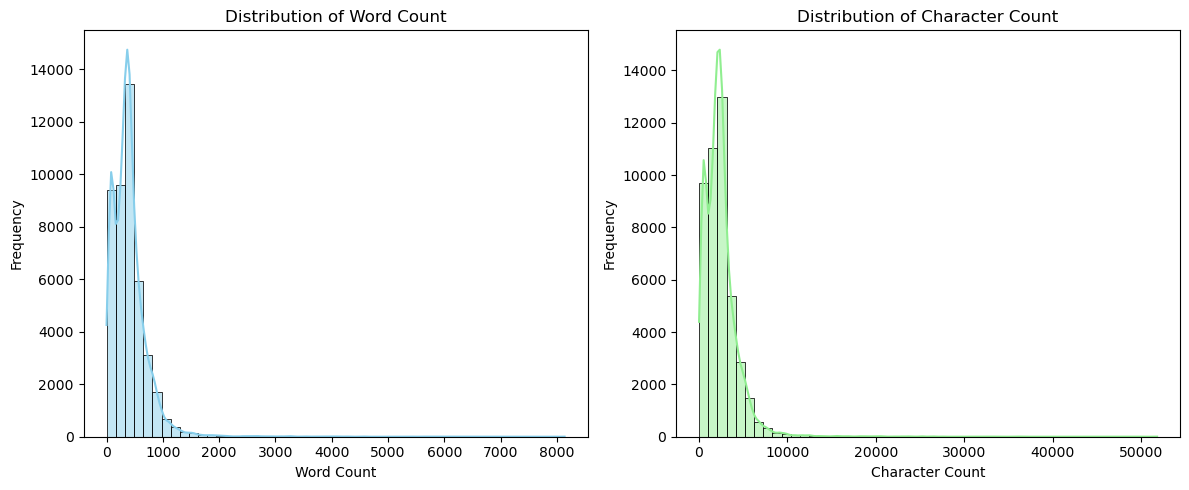

In [74]:
# Word VS Character count distribution
# Compute Word Count and Character Count
news["word_count"] = news["text"].apply(lambda x: len(str(x).split()))
news["char_count"] = news["text"].apply(lambda x: len(str(x)))

# Plotting Distribution of Word Count
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(news["word_count"], bins=50, kde=True, color="skyblue", edgecolor="black")
plt.title("Distribution of Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

# Plotting Distribution of Character Count
plt.subplot(1,2,2)
sns.histplot(news["char_count"], bins=50, kde=True, color="lightgreen", edgecolor="black")
plt.title("Distribution of Character Count")
plt.xlabel("Character Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Key Observations :**

1) Both Distributions are Right-Skewed (Long Tail)
2) Most articles have low word and character counts.
3) A few articles have extremely high counts (outliers).

| Metric              | Majority Range (Visual Estimate) |
| ------------------- | -------------------------------- |
| **Word Count**      | **0 - 800 words**                |
| **Character Count** | **0 - 5000 characters**          * 


Typical in text datasets where some articles are short summaries, while others are long repo

**Presence of Outliers (Long Articles) :**

1) Articles with >2000 words or >10,000 characters are very rare.
2) These long tail outliers could be:
    A) Comprehensive investigative reports.
    B) Duplicated concatenated articles.
    C) Scraping artifacts.

| Insight                    | Actionable Decision                                                                                 |
| -------------------------- | --------------------------------------------------------------------------------------------------- |
| Extreme Outliers           | Consider **capping/truncating article lengths** during preprocessing (e.g., 95th percentile cutoff  |
| Distribution Understanding | Word/Char count can be used as **features** to help model detect suspiciously short (clickbait-li|
|                            | e) or extremely l ng articles (potential filler conten                                              ). |
| Data Cleaning              | Check very short articles (e.g., <50 words) for **empty or noise-filled entrie                      |

  r 
  |
ts.

- The dataset is dominated by short to medium-length articles.
- Outliers exist but are few,might need handling depending on model sensitivity.

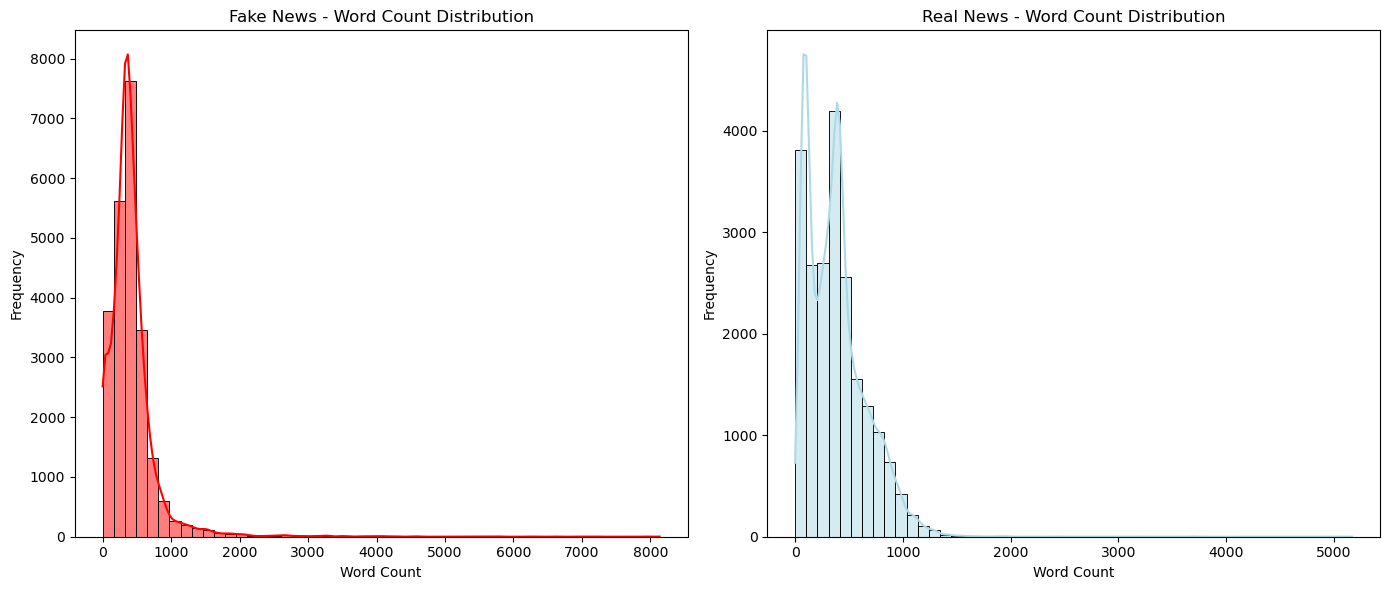

In [75]:
# Fake news word count VS true news word count distribution 

plt.figure(figsize=(14, 6))

# Plot Word Count Distribution for Fake News
plt.subplot(1, 2, 1)
sns.histplot(news[news["label"] == "fake"]["word_count"], bins=50, kde=True, color="red", edgecolor="black")
plt.title("Fake News - Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

# Plot Word Count Distribution for Real News
plt.subplot(1, 2, 2)
sns.histplot(news[news["label"] == "true"]["word_count"], bins=50, kde=True, color="lightblue", edgecolor="black")
plt.title("Real News - Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Fake News Word Count Insights :**

1) Fake news articles are clustered between 200–800 words.
2) Very few fake articles exceed 1000 words.
3) The distribution is tightly packed and sharply declines after 800 words.
4) Indicates fake news tends to be shorter, concise, and potentially clickbait-like.

**Real News Word Count Insights :**

1) Real news articles are also most frequent in the 200–800 words range.
2) However, the spread is wider, with more articles exceeding 1000 words compared to fake news.
3) Real news has a more gradual decline, suggesting longer, detailed articles are common.
4) Indicates real news tends to be longer and more comprehensive in coverage.

| Observation                              | Fake News                                        | Real News                               |
| ---------------------------------------- | ------------------------------------------------ | --------------------------------------- |
| Dominant Word Count Range                | 200–800 words                                    | 200–800 words                           |
| Frequency of Long Articles (>1000 words) | Very rare                                        | More common                             |
| Distribution Spread                      | Narrow, sharp drop-off                           | Wider, gradual taper                    |
| Possible Conclusion                      | Short, catchy articles, possibly sensationalized | More structured and detaarticle.   c

l**Insight's :**
1) Fake news articles prioritize brevity and impact → Supports the theory that fake news aims for quick virality.
2) Real news articles are typically longer → Reflects journalistic depth and detailed reporting.
3) This word count distribution difference can be used as a feature in classification models.es |


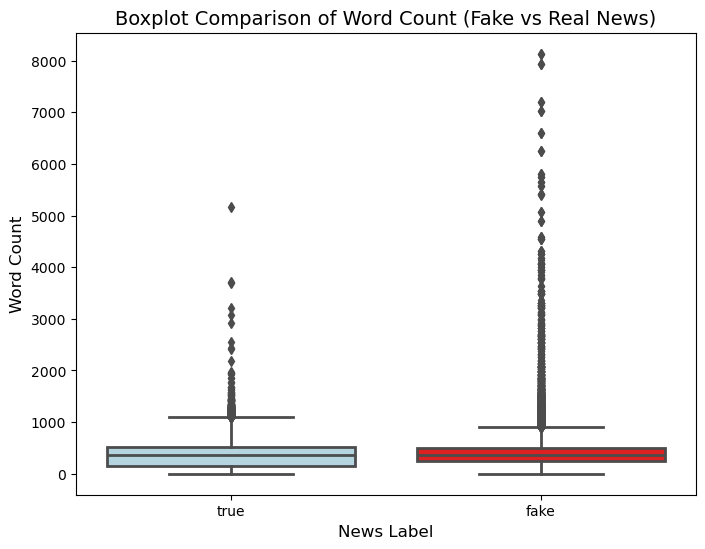

In [76]:
# Outliers in fake vs true news on basis of word count
plt.figure(figsize = (8, 6))
sns.boxplot(
    data = news, 
    x    = "label", 
    y    = "word_count", 
    palette = {"fake": "red", "true": "lightblue"},
    showfliers = True,  # To show outliers
    linewidth = 2
)

plt.title("Boxplot Comparison of Word Count (Fake vs Real News)", fontsize=14)
plt.xlabel("News Label", fontsize=12)
plt.ylabel("Word Count", fontsize=12)
plt.show()

In [77]:
# Grouping by Label to get Mean and Median Word Count
word_count_stats = news.groupby("label")["word_count"].agg(["mean", "median"]).reset_index()

# Display the results
print(word_count_stats)

  label        mean  median
0  fake  423.375570   363.0
1  true  385.640099   359.0


**Insights :**

| Observation            | True News                                              | Fake News                                                 |
| ---------------------- | ------------------------------------------------------ | --------------------------------------------------------- |
| **Mean Word Count**    | Lower → Shorter articles on average                    | Higher → Longer articles on average                       |
| **Median Word Count**  | Lower → Majority of Fake articles are bit more brief   | Higher → Real articles are more detailed                  |
| **IQR (from boxplot)** | Narrower → Consistent short articles                   | Wider → Diverse lengths (news reports, in-depth articles) |

### Date column

**Analyzing the temporal distribution (by Month, Year, Quarter) of Fake vs Real news can reveal trends like :**

1) Misinformation spikes during elections/events.
2) Whether Fake news articles cluster in certain periods compared to Real news.
3) Content publishing patterns over time cycles (quarterly, yearly).

In [78]:
# Extract Year, Month, Quarter and creating new features as year month and quarter
news["year"] = news["date"].dt.year
news["month"] = news["date"].dt.month
news["quarter"] = news["date"].dt.quarter

In [79]:
news.sample(5)

title  \
14148  HILLARY CLINTON: We All Know She’s Deceitful A...   
29282  Trump aims to expand U.S. offshore drilling, d...   
19849   WATCH: Conservative ‘Christian’ Leader Says W...   
40886  [VIDEO] Obama Needed A Girl To Take Down Mitt ...   
13139  Unforced errors and miscalculations end Bush's...   

                                                    text          subject  \
14148   She was an unethical, dishonest lawyer. She c...         politics   
29282  WASHINGTON (Reuters) - U.S. President Donald T...     politicsNews   
19849  A prominent conservative  Christian  is callin...             News   
40886  Because Obama s doing such a great job keeping...  Government News   
13139  CHARLESTON, S.C. (Reuters) - Before Donald Tru...     politicsNews   

            date label  word_count  char_count  year  month  quarter  
14148 2015-04-15  fake        2670       15818  2015      4        2  
29282 2017-04-28  true         698        4361  2017      4        2  
19849 2016-08-13  fake         592        3476  2016      8        3  
40886 2015-11-03  fake         115         605  2015     11        4  
13139 2016-02-20  true        1258        7497  2016      2        1

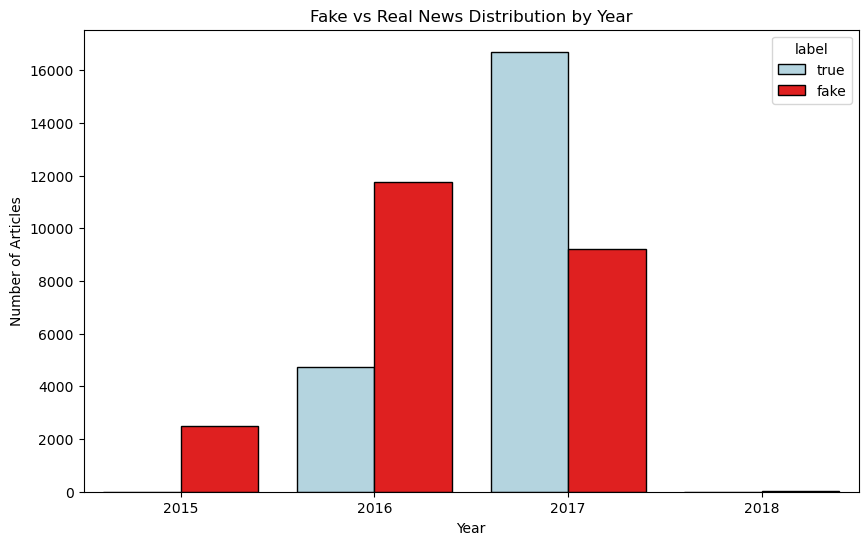

In [80]:
# Plotting Articles by Year (Fake vs Real):
plt.figure(figsize=(10,6))
sns.countplot(data = news, x = "year", hue = "label", palette = {"fake": "red", "true": "lightblue"}, edgecolor = "black")
plt.title("Fake vs Real News Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.show()

In [81]:
# Checking which subject has the most fake-news (year-wise)
news[(news["label"] == "fake") & (news["year"] == 2015)]["subject"].value_counts()

subject
politics           1158
left-news           740
Government News     581
Name: count, dtype: int64

In [82]:
news[(news["label"] == "fake") & (news["year"] == 2016)]["subject"].value_counts()

subject
News               5841
politics           2706
left-news          1805
Government News     597
US_News             405
Middle-east         400
Name: count, dtype: int64

In [83]:
news[(news["label"] == "fake") & (news["year"] == 2017)]["subject"].value_counts()

subject
News               3209
politics           2937
left-news          1911
Government News     390
Middle-east         378
US_News             378
Name: count, dtype: int64

In [84]:
news[(news["label"] == "true") & (news["year"] == 2017)]["subject"].value_counts()

subject
worldnews       10145
politicsNews     6556
Name: count, dtype: int64

**Finding according to our data :**
- 2015 is the year when no true news was published.And reason could be that year many elections took place and contesting parties make many falls claim
  in order to win election. As majority of fake news comes from politics subject news.
- 2017 is the only year when true news dominated fake news.
- 2016 being the year when fake news were more than twice the true news.

In [85]:
# Lets see whether month and quarter are somehow related to type of news being published 
# Month -- 
news[news["label"] == "fake"]["month"].value_counts().sort_index()

month
1     2110
2     1934
3     2162
4     2108
5     2177
6     1921
7     1951
8     1907
9     1774
10    1968
11    1803
12    1656
Name: count, dtype: int64

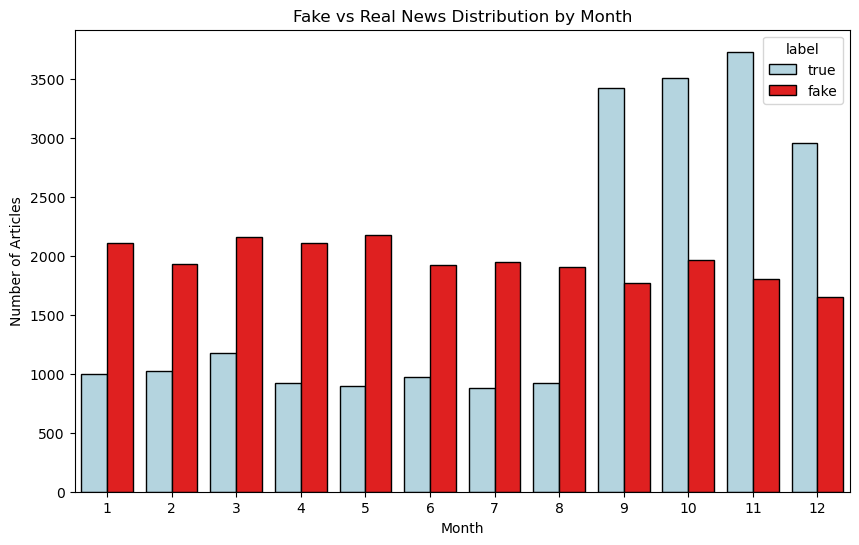

In [86]:
# visual representation 
plt.figure(figsize = (10,6))
sns.countplot(data = news, x = "month", hue = "label", palette = {"fake": "red", "true": "lightblue"}, edgecolor = "black")
plt.title("Fake vs Real News Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.show()

- Fake news is consistently high across months January to May.
- It then drops from June to December, especially after August.
- True news, on the other hand, is low at the start of the year, but spikes from September to December with peaks in October & November.

- Interestingly, true news volume significantly increases toward the last quarter of the year, while fake news remains relatively higher in the earlier months. 
- This may indicate that misinformation often precedes key events,possibly to shape public opinion,whereas real news spikes as events actually unfold.

In [87]:
# Quarter -- 
news[news["label"] == "fake"]["quarter"].value_counts().sort_index()

quarter
1    6206
2    6206
3    5632
4    5427
Name: count, dtype: int64

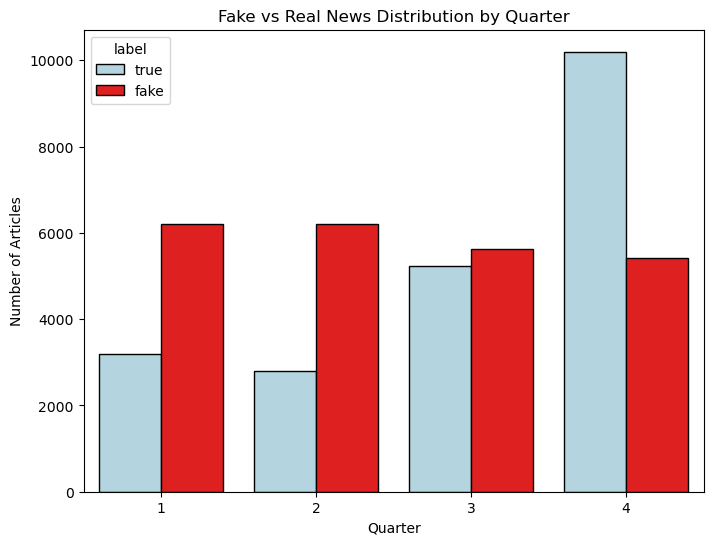

In [88]:
# visual representation 
plt.figure(figsize=(8,6))
sns.countplot(data=news, x="quarter", hue="label", palette={"fake": "red", "true": "lightblue"}, edgecolor="black")
plt.title("Fake vs Real News Distribution by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Number of Articles")
plt.show()

- 4th quarter has the most true news as most of the fake news that started as theories during initial quarter come's to the end by the quarter 4th.
- And we can easily assume that during the first and 2 nd quarter due to less proof and misinformation fake news number are higher but as time pass by
  they dilute.  

In [89]:
news.groupby("year")["quarter"].value_counts()

year  quarter
2015  2            900
      4            858
      3            713
      1              8
2016  4           4392
      1           4357
      2           4056
      3           3665
2017  4          10376
      3           6479
      1           4999
      2           4050
2018  1             35
Name: count, dtype: int64

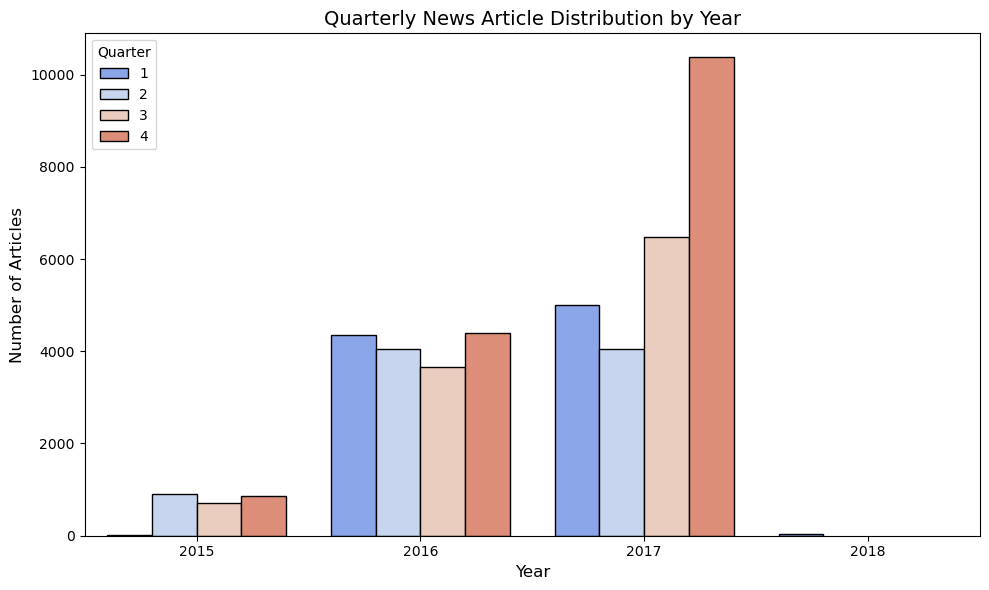

In [90]:
# Prepare data for plotting
quarterly_dist = news.groupby(["year", "quarter"]).size().reset_index(name="count")
quarterly_dist["quarter"] = quarterly_dist["quarter"].astype(str)  # Fix for the error

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=quarterly_dist, x="year", y="count", hue="quarter", palette="coolwarm", edgecolor="black")

# Formatting
plt.title("Quarterly News Article Distribution by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.legend(title="Quarter")
plt.tight_layout()
plt.show()

## Basic Text Pre-Processing 

In [91]:
# data preview 
news.head()

title  \
0   Suicide attack targets area southeast of Baghdad   
1  FLASHBACK: WATCH TED CRUZ Promise To Support D...   
2  Boris Johnson gives PM May advice on Brexit wh...   
3  India struggles to rein in border flows of cat...   
4  In speech, Trump tries to turn from divisive t...   

                                                text       subject       date  \
0  BAGHDAD (Reuters) - Two attackers shot several...     worldnews 2017-11-27   
1      Yes, he did promise to support Donald Trump:       politics 2016-07-21   
2  MANCHESTER, England (Reuters) - British Foreig...     worldnews 2017-10-03   
3  NEW DELHI (Reuters) - Stopping Rohingya refuge...     worldnews 2017-10-05   
4  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews 2017-03-01   

  label  word_count  char_count  year  month  quarter  
0  true         146         930  2017     11        4  
1  fake           8          45  2016      7        3  
2  true         632        3797  2017     10        4  
3  true         515        3067  2017     10        4  
4  true         799        5112  2017      3        1

### Text column cleaning {removing email_id's,url's,white space's,html tags and lowercasing}

In [92]:
# Check how many rows contain HTML tags in text column
html_tagged = news['text'].apply(lambda x: bool(re.search(r"<[^>]+>", x)))
print("Rows with HTML tags:", html_tagged.sum())

# To preview a few rows with HTML
news[html_tagged].head()

Rows with HTML tags: 87


title  \
111   PRINCIPAL’S REASON FOR NOT ALLOWING This Pictu...   
1754  Battered U.S. coal industry hopes for Trump, p...   
1812   The ‘Fake Melania Trump’ Conspiracy Theory Is...   
2215  In battleground Florida, tough stance on felon...   
2547  FLORIDA CAR DEALER THREATENED WITH FINES FOR D...   

                                                   text       subject  \
111   A North Dakota father is calling for the resig...     left-news   
1754  WASHINGTON (Reuters) - Republican presidential...  politicsNews   
1812  The Internet is going crazy after photos, vide...          News   
2215  TALLAHASSEE, Fla. (Reuters) - Leonard “Roscoe”...  politicsNews   
2547  It doesn t get much more anti-American than fo...     left-news   

           date label  word_count  char_count  year  month  quarter  
111  2015-12-12  fake         784        4855  2015     12        4  
1754 2016-11-04  true         728        4539  2016     11        4  
1812 2017-10-18  fake         614        3649  2017     10        4  
2215 2016-10-24  true        1400        8964  2016     10        4  
2547 2015-07-02  fake         270        2475  2015      7        3

In [93]:
# Total number of rows containing html tags
news[html_tagged].shape[0]

87

In [94]:
url_flag = news["text"].str.contains(r"http[s]?://", regex=True)
print("Rows with URLs:", url_flag.sum())

Rows with URLs: 3290


In [95]:
email_flag = news["text"].str.contains(r"\S+@\S+", regex=True)
print("Rows with email addresses:", email_flag.sum())

Rows with email addresses: 5616


In [96]:
non_ascii = news["text"].apply(lambda x: not x.isascii())
print("Rows with non-ASCII characters:", non_ascii.sum())

Rows with non-ASCII characters: 10849


In [97]:
# Function to remove all the unwanted things from our text column

def clean_text(text):
    
    text = str(text)  # Ensure it's a string

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove email addresses
    text = re.sub(r"\S+@\S+", "", text)

    # Remove non-ASCII characters
    text = text.encode("ascii", errors="ignore").decode()

    # Convert to lowercase
    text = text.lower()

    # Remove leading/trailing and multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [98]:
# new feature that holds cleaned text (free from url,email,non ascii chars or html tags)
news["clean_text"] = news["text"].apply(clean_text)

In [99]:
# Proof that the html tags are removed
# Check how many rows contain HTML tags in text column
html_tagged1 = news["clean_text"].apply(lambda x: bool(re.search(r"<[^>]+>", x)))
print("Rows with HTML tags:", html_tagged1.sum())

# To preview a few rows with HTML
news[html_tagged1].shape

Rows with HTML tags: 0


(0, 11)

In [100]:
url_flag1 = news["clean_text"].str.contains(r"http[s]?://", regex=True)
print("Rows with URLs:", url_flag1.sum())

Rows with URLs: 0


In [101]:
email_flag1 = news["clean_text"].str.contains(r"\S+@\S+", regex=True)
print("Rows with email addresses:", email_flag1.sum())

Rows with email addresses: 1


In [102]:
non_ascii1 = news["clean_text"].apply(lambda x: not x.isascii())
print("Rows with non-ASCII characters:", non_ascii1.sum())

Rows with non-ASCII characters: 0


In [103]:
# Shape of our dataset with cleaned text column (we didn't drop the rows we just cleaned them)
news.shape

(44888, 11)

### Title Column {removing email_id's,url's,white space's,html tags and lowercasing}

In [104]:
# Check how many rows contain HTML tags in title column
html_tagged2 = news['title'].apply(lambda x: bool(re.search(r"<[^>]+>", x)))
print("Rows with HTML tags:", html_tagged2.sum())

# To preview a few rows with HTML
news[html_tagged2]
# No html tags in this column

Rows with HTML tags: 0


Empty DataFrame
Columns: [title, text, subject, date, label, word_count, char_count, year, month, quarter, clean_text]
Index: []

In [105]:
url_flag2 = news["title"].str.contains(r"http[s]?://", regex=True)
print("Rows with URLs:", url_flag2.sum())
# no url_flagged in title column

Rows with URLs: 0


In [106]:
email_flag2 = news["title"].str.contains(r"\S+@\S+", regex=True)
print("Rows with email addresses:", email_flag2.sum())

Rows with email addresses: 3


In [107]:
non_ascii2 = news["title"].apply(lambda x: not x.isascii())
print("Rows with non-ASCII characters:", non_ascii2.sum())

Rows with non-ASCII characters: 14726


In [108]:
# Function to clean email and non asci value from title column

def clean_title(text):
    
    text = str(text)  # Ensure it's a string

    # Remove email addresses
    text = re.sub(r"\S+@\S+", "", text)

    # Remove non-ASCII characters
    text = text.encode("ascii", errors="ignore").decode()

    # Convert to lowercase
    text = text.lower()

    # Remove leading/trailing and multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [109]:
# new feature that holds cleaned title (free from email,non ascii chars)
news["clean_title"] = news["title"].apply(clean_title)

In [110]:
# new shape of dataset
news.shape

(44888, 12)

### Removing punctuations from text and title column [cleaned_version]
**Resaons for removing punctuations from our text :**
- when we do tokenization of our words to do feature engg. our text can be treated as separate words. for example -- {hello! and hello}
  and this can confuse our model as it will treat them as d|f words.
- Our words can be treated as such:-
- Sentence = Hello!,how are you ? {after tokenization} --> Hello,!,how,are,you,? 

In [111]:
news.sample()

title  \
27684  RADICAL “TOLERANT” FEMALE Antifa, Black Bloc, ...   

                                                    text    subject  \
27684  DC Antifa Leader Moved to Turkey with Man She ...  left-news   

            date label  word_count  char_count  year  month  quarter  \
27684 2017-05-04  fake         294        1783  2017      5        2   

                                              clean_text  \
27684  dc antifa leader moved to turkey with man she ...   

                                             clean_title  
27684  radical tolerant female antifa, black bloc, le...

In [112]:
# removing punctuation's from text and title column 
exclude = string.punctuation
# exclude is holding all the value's considered as punctuation
exclude

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [113]:
# function to remove punctuation from clean_text and clean_title column
def remove_punc(text):
    return text.translate(str.maketrans("","",exclude))

In [114]:
# remove punctuation from clean_title column
news["clean_title"] = news["clean_title"].apply(remove_punc)

In [115]:
# remove punctuation from clean_text column
news["clean_text"] = news["clean_text"].apply(remove_punc)

In [116]:
news.clean_text[0]

'baghdad reuters  two attackers shot several civilians on monday in the nahrawan area southeast of baghdad before one blew himself up and the other was killed by security forces the iraqi interior ministry said without providing official casualty figures local media reported at least 17 people were killed and 28 wounded islamic state claimed responsibility for the attack described by an interior ministry spokesman as a terrorist attack by two terrorist suicide attackers who fired indiscriminately on citizens in the nahrawan area  the sunni muslim militant group s amaq news agency said it had killed 35 members of one of the iranbacked shi ite militias known as the popular mobilisation forces iraqi security officials say islamic state is likely to wage an insurgency after its selfproclaimed caliphate collapsed and its militants were dislodged from territories they held across a swathe of iraq and syria'

### Spelling Correction  
- taking too much time so i am droping this idea

In [117]:
# Function to correct spelling (was really time-consuming so add a filter to it)
def fast_spell_correct(text):
    try:
        # Only correct short texts (e.g., < 100 characters)
        if len(text) < 100:
            return str(TextBlob(text).correct())
        else:
            return text
    except:
        return text

In [118]:
# Apply to clean_title column
# news["clean_title"] = news["clean_title"].apply(correct_spelling)

In [119]:
# Apply to clean_text column
# news["clean_text"] = news["clean_text"].apply(correct_spelling)

### Removing stopwords from textual data
- As they dont contribute much in meaning of sentence.But they are important when we do pos [part of speech tagging].

In [120]:
# List of all the engliash words considered as stop-words
print(stopwords.words("english"),end = "")

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [121]:
# Load stopwords once (optimized)
stop_words = set(stopwords.words("english"))

def remove_stopwords_from_column(df, column_name, new_column_name = "cleaned_text"):
    def clean_text(text):
        text = str(text).lower()                         # Lowercase
        text = re.sub(r"[^a-z\s]", "", text)             # Keep only letters and spaces
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        return " ".join(filtered_words)

    df[new_column_name] = df[column_name].apply(clean_text)
    return df

In [122]:
# Removing stop_words from clean_text column
news = remove_stopwords_from_column(news, "clean_text", "clean_text_no_stopwords")

In [123]:
# Removing stop_words from clean_text column
news = remove_stopwords_from_column(news, "clean_title", "clean_title_no_stopwords")

### Emoji's Detection 
- if they exsits changing the emoticons to their literal meaning

In [124]:
# Emoji pattern (matches most emojis using Unicode ranges)
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    u"\U00002702-\U000027B0"  # Dingbats
    u"\U000024C2-\U0001F251"  # Enclosed characters
    "]+", flags=re.UNICODE)

def contains_emoji(text):
    return bool(emoji_pattern.search(str(text)))

In [125]:
# Check if any row contains emoji in clean_text_no_stopwords column
emoji_rows = news["clean_text_no_stopwords"].apply(contains_emoji)

# Count of rows with emojis
print("Rows with emojis:", emoji_rows.sum())

# view them
news[emoji_rows].head()

Rows with emojis: 0


Empty DataFrame
Columns: [title, text, subject, date, label, word_count, char_count, year, month, quarter, clean_text, clean_title, clean_text_no_stopwords, clean_title_no_stopwords]
Index: []

In [126]:
# Check if any row contains emoji in clean_title_no_stopwords column
emoji_rows = news["clean_title_no_stopwords"].apply(contains_emoji)

# Count of rows with emojis
print("Rows with emojis:", emoji_rows.sum())

# view them
news[emoji_rows].head()

Rows with emojis: 0


Empty DataFrame
Columns: [title, text, subject, date, label, word_count, char_count, year, month, quarter, clean_text, clean_title, clean_text_no_stopwords, clean_title_no_stopwords]
Index: []

- Since we have no emoji in any of the text column we don't need to handle them.

## Feature Selection
- Manually based on knowledge and gathered information

In [127]:
# Preview of our data 
news.sample()

title  \
16565  Britain's Boris Johnson accused of Brexit 'bac...   

                                                    text    subject  \
16565  LONDON (Reuters) - Britain s foreign minister ...  worldnews   

            date label  word_count  char_count  year  month  quarter  \
16565 2017-09-17  true         497        2915  2017      9        3   

                                              clean_text  \
16565  london reuters  britain s foreign minister bor...   

                                             clean_title  \
16565  britains boris johnson accused of brexit backs...   

                                 clean_text_no_stopwords  \
16565  london reuters britain foreign minister boris ...   

                                clean_title_no_stopwords  
16565  britains boris johnson accused brexit backseat...

In [282]:
# Lets take out all the unnecessaries columns and make a subset of our dataset to avoid confusion and feature that are required for modelling
news_final = news.copy()

In [283]:
# Preview of new dataset
news_final = news_final[['clean_title_no_stopwords','clean_text_no_stopwords','subject','word_count','char_count','month','label']]
news_final

clean_title_no_stopwords  \
0          suicide attack targets area southeast baghdad   
1      flashback watch ted cruz promise support donal...   
2      boris johnson gives pm may advice brexit parad...   
3      india struggles rein border flows cattle rohingya   
4             speech trump tries turn divisive dealmaker   
...                                                  ...   
44883  nigeria says us agrees delayed million fighter...   
44884                           boiler room hello gutter   
44885                illegal kids able avoid deportation   
44886  republican tax plan would deal financial hit u...   
44887  un refugee commissioner says australia must st...   

                                 clean_text_no_stopwords          subject  \
0      baghdad reuters two attackers shot several civ...        worldnews   
1                       yes promise support donald trump         politics   
2      manchester england reuters british foreign sec...        worldnews   
3      new delhi reuters stopping rohingya refugees c...        worldnews   
4      washington reuters us president donald trump s...     politicsNews   
...                                                  ...              ...   
44883  abuja reuters united states formally agreed se...        worldnews   
44884  tune alternate current radio network acr anoth...      Middle-east   
44885  know illegal minors deported thomas homan head...  Government News   
44886  washington reuters republican tax plan unveile...     politicsNews   
44887  sydney reuters un high commissioner refugees s...        worldnews   

       word_count  char_count  month label  
0             146         930     11  true  
1               8          45      7  fake  
2             632        3797     10  true  
3             515        3067     10  true  
4             799        5112      3  true  
...           ...         ...    ...   ...  
44883         284        1703     12  true  
44884         169        1024      6  fake  
44885         494        2879      2  fake  
44886         416        2680     11  true  
44887         553        3288     11  true  

[44888 rows x 7 columns]

In [284]:
# Combining the clean_text_no_stopwords and clean_title_no_stopwords column and renaming them back to [title and text] colum
news_final["combined_text"] = news_final["clean_title_no_stopwords"] + " " + news_final["clean_text_no_stopwords"]

In [285]:
# droping the columns [clean_text_no_stopwords and clean_title_no_stopwords]
news_final.drop(columns = ["clean_text_no_stopwords","clean_title_no_stopwords"],inplace = True)

In [286]:
# Final dataset preview and column rearrangement 
desired_order = ["combined_text","subject","word_count","char_count","month","label"]
news_final = news_final[desired_order]
news_final

combined_text          subject  \
0      suicide attack targets area southeast baghdad ...        worldnews   
1      flashback watch ted cruz promise support donal...         politics   
2      boris johnson gives pm may advice brexit parad...        worldnews   
3      india struggles rein border flows cattle rohin...        worldnews   
4      speech trump tries turn divisive dealmaker was...     politicsNews   
...                                                  ...              ...   
44883  nigeria says us agrees delayed million fighter...        worldnews   
44884  boiler room hello gutter tune alternate curren...      Middle-east   
44885  illegal kids able avoid deportation know illeg...  Government News   
44886  republican tax plan would deal financial hit u...     politicsNews   
44887  un refugee commissioner says australia must st...        worldnews   

       word_count  char_count  month label  
0             146         930     11  true  
1               8          45      7  fake  
2             632        3797     10  true  
3             515        3067     10  true  
4             799        5112      3  true  
...           ...         ...    ...   ...  
44883         284        1703     12  true  
44884         169        1024      6  fake  
44885         494        2879      2  fake  
44886         416        2680     11  true  
44887         553        3288     11  true  

[44888 rows x 6 columns]

## Encoding,Vectorization,Spliting and Pipelines

- Applying Label Encoder on label column as it contains categorical data and it is our output label.

In [287]:
encoder = LabelEncoder()
news_final['label'] = encoder.fit_transform(news_final['label'])

In [134]:
# dataset preview
news_final.sample(2,random_state = 4)
# our label column now contains 0 and 1 only numerical data. [0 == fake,1 == true]

combined_text    subject  \
1983   thai university removes student leader defying...  worldnews   
43212  megyn kelly laughably claims fox news rightwin...       News   

       word_count  char_count  month  label  
1983          395        2499      9      1  
43212         783        4381      4      0

In [288]:
news_final["combined_text"][1]

'flashback watch ted cruz promise support donald trump republican candidate video yes promise support donald trump'

**Vectorization :** 
- I am using the CountVectorizer approach to transform textual data into numerical vectors so that the machine learning model can process it effectively.
- CountVectorizer is chosen over One-Hot Encoding because it retains word frequency information and produces a more compact, informative feature space.
- Since the task is misinformation classification and not sentiment analysis, I am initially avoiding n-grams to ensure faster computation and reduced feature dimensionality.
- CountVectorizer in combination with algorithms like Logistic Regression or Naive Bayes is well-suited for this type of binary text classification problem.
- Converting text column [combined_text] into vectors
- Before Vectorization spliting the data into training and test data.

In [180]:
# Shape of the dataset 
news_final.shape

(44888, 6)

In [185]:
# Separating input and output features as X and y 
X = news_final.iloc[::,:-1]
y = news_final.iloc[::,-1]
print(X.shape)
print(y.shape)

(44888, 5)
(44888,)


In [187]:
# train-test-splt 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,stratify = y,random_state = 42)

In [188]:
print("We have",X_train.shape[0],"rows in the X_train as training data.")
print("We have",X_test.shape[0],"rows in the X_test as test data.")

We have 40399 rows in the X_train as training data.
We have 4489 rows in the X_test as test data.


### Pipeline (Logistic Regression Model) 01

In [191]:
X_train

combined_text          subject  \
36072  bernie sues allow year olds vote next law suit...        left-news   
30955  turks safe germany merkel says dismissing anka...        worldnews   
40576  trump could win landslide prepare laugh ah ult...             News   
3864   wow obama media ally exposes huge lie obama re...  Government News   
6533   british columnist katie hopkins brutal reactio...         politics   
...                                                  ...              ...   
32973  lol democrat congressman says best way fight f...         politics   
28412  yemen dismayed trumps immigration order offici...     politicsNews   
34527  byebye harvey weinsteins wife mother young kid...         politics   
27459  watch brian stelter slams sean hannity disturb...             News   
36839  britains labour says cannot vote eu withdrawal...        worldnews   

       word_count  char_count  month  
36072         563        3442      3  
30955         251        1503      9  
40576         475        2621     11  
3864          573        3421     11  
6533          428        2653      2  
...           ...         ...    ...  
32973         124         729      3  
28412         101         637      1  
34527         681        4254     10  
27459         339        2075      8  
36839         144         870      9  

[40399 rows x 5 columns]

In [192]:
# Column transformer
preprocessor = ColumnTransformer(
                                 transformers = [
                                                ("text", CountVectorizer(), "combined_text"),  # text vectorization
                                                ("cat", OneHotEncoder(handle_unknown = "ignore"), ["subject"]),   # encode categories
                                                ("num", StandardScaler(), ["word_count", "char_count", "month"])  # scale numbers
])

In [193]:
# Pipeline with model
model = Pipeline([
                    ("preprocess", preprocessor),
                    ("classifier", LogisticRegression())
])

In [194]:
# Train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text', CountVectorizer(),
                                                  'combined_text'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject']),
                                                 ('num', StandardScaler(),
                                                  ['word_count', 'char_count',
                                                   'month'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [195]:
# Evaluate
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 1.0


In [197]:
train_set = X_train.merge(X_test, how="inner")
print("Overlapping rows:", train_set.shape[0])

Overlapping rows: 44


In [199]:
dummy = DummyClassifier(strategy = "most_frequent")
dummy.fit(X_train, y_train)
print("Dummy Accuracy:", accuracy_score(y_test, dummy.predict(X_test)))

Dummy Accuracy: 0.5228335932278904


In [200]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2347    0]
 [   0 2142]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2347
           1       1.00      1.00      1.00      2142

    accuracy                           1.00      4489
   macro avg       1.00      1.00      1.00      4489
weighted avg       1.00      1.00      1.00      4489



In [201]:
y_train_shuffled = np.random.permutation(y_train)
model.fit(X_train, y_train_shuffled)
print("Accuracy after shuffling labels:", model.score(X_test, y_test))

Accuracy after shuffling labels: 0.49721541546001335


- After understanding all the results from the logistic regression pipeline. The results appeared to good to be true,Hence run some extra test's
  and came to a conclusion that subject feature is highly influencing the outcome as some subject type are all fake and some are true.
- And this feature may be causing data leakage or overfitting on our model.And in actual our model is not learning anything from the data and
  just memorizing the pattern.
- So, therefore I am going to train a new model[pipeline 2] with same parameter just removing subject feature from the train or labelled data.

### Pipeline (Logistic Regression) 02 {without subject column}

In [241]:
news_final = news_final.drop_duplicates(subset=["combined_text", "word_count", "char_count", "month", "label"])

In [242]:
# Separating input and output features as X and y 
X = news_final.iloc[::,:-1]
y = news_final.iloc[::,-1]
print(X.shape)
print(y.shape)

(39081, 5)
(39081,)


In [243]:
# train-test-splt 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,stratify = y,random_state = 42)

In [244]:
print("We have",X_train.shape[0],"rows in the X_train as training data.")
print("We have",X_test.shape[0],"rows in the X_test as test data.")

We have 35172 rows in the X_train as training data.
We have 3909 rows in the X_test as test data.


In [245]:
# Column transformer
preprocessor = ColumnTransformer(
                                 transformers = [
                                                ("text", CountVectorizer(), "combined_text"),  # text vectorization
                                                ("num", StandardScaler(), ["word_count", "char_count", "month"])  # scale numbers
])

In [246]:
# Pipeline with model
model = Pipeline([
                    ("preprocess", preprocessor),
                    ("classifier", LogisticRegression())
])

In [247]:
# Train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text', CountVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count', 'char_count',
                                                   'month'])])),
                ('classifier', LogisticRegression())])

In [248]:
# Evaluate
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9956510616525965


In [250]:
train_set = X_train.merge(X_test, how="inner")
print("Overlapping rows:", train_set.shape[0])

Overlapping rows: 0


In [251]:
dummy = DummyClassifier(strategy = "most_frequent")
dummy.fit(X_train, y_train)
print("Dummy Accuracy:", accuracy_score(y_test, dummy.predict(X_test)))

Dummy Accuracy: 0.5418265541059094


In [252]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1782    9]
 [   8 2110]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1791
           1       1.00      1.00      1.00      2118

    accuracy                           1.00      3909
   macro avg       1.00      1.00      1.00      3909
weighted avg       1.00      1.00      1.00      3909



### Logistic Regression Model {without subject column and other column's which we cretaed}
- Reason for that it is possible that date month etc features will not be provided in prediction stage and it could have been causing data leakage
- Accuracy 99%

In [356]:
news_final = news_final.drop_duplicates(subset=["combined_text", "word_count", "char_count", "month", "label"])

In [357]:
# Separating input and output features as X and y 
X = news_final[["combined_text"]]
y = news_final["label"]
print(X.shape)
print(y.shape)

(39081, 1)
(39081,)


In [358]:
# train-test-splt 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,stratify = y,random_state = 42)

In [359]:
print("We have",X_train.shape[0],"rows in the X_train as training data.")
print("We have",X_test.shape[0],"rows in the X_test as test data.")

We have 35172 rows in the X_train as training data.
We have 3909 rows in the X_test as test data.


In [360]:
# Column transformer
preprocessor = ColumnTransformer(
                                 transformers = [
                                                ("text", CountVectorizer(), "combined_text")]) # text vectorization

In [361]:
# Pipeline with model
model = Pipeline([
                    ("preprocess", preprocessor),
                    ("classifier", LogisticRegression())
])

In [362]:
# Train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text', CountVectorizer(),
                                                  'combined_text')])),
                ('classifier', LogisticRegression())])

In [363]:
# Evaluate
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9961627014581734


In [364]:
train_set = X_train.merge(X_test, how="inner")
print("Overlapping rows:", train_set.shape[0])

Overlapping rows: 2


In [365]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1783    8]
 [   7 2111]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1791
           1       1.00      1.00      1.00      2118

    accuracy                           1.00      3909
   macro avg       1.00      1.00      1.00      3909
weighted avg       1.00      1.00      1.00      3909



In [366]:
overlap = set(X_train["combined_text"]).intersection(set(X_test["combined_text"]))
print("Overlapping rows:", len(overlap))

Overlapping rows: 2


In [367]:
y_train_shuffled = np.random.permutation(y_train)
model.fit(X_train, y_train_shuffled)
print("Accuracy after shuffling labels:", model.score(X_test, y_test))

Accuracy after shuffling labels: 0.4960347915067792


<Axes: >

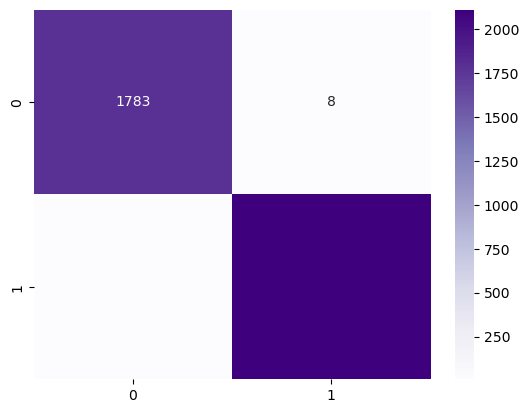

In [368]:
cm_lg = confusion_matrix(y_test,y_pred)
sns.heatmap(cm_lg, annot = True, cmap = "Purples", fmt = "d")

### Naive Baye's Model (on combined_text and label column)
- Accuracy 95%

In [331]:
# Column transformer
preprocessor = ColumnTransformer(
                                 transformers = [
                                                ("text", CountVectorizer(), "combined_text")]) # text vectorization

In [332]:
# Pipeline with model
model = Pipeline([
                    ("preprocess", preprocessor),
                    ("classifier", MultinomialNB())
])

In [333]:
# Train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text', CountVectorizer(),
                                                  'combined_text')])),
                ('classifier', MultinomialNB())])

In [334]:
# Evaluate
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9549756971092351


### Random Forest Classifier
- Accuracy is 98% 

In [336]:
# Column transformer
preprocessor = ColumnTransformer(
                                 transformers = [
                                                ("text", CountVectorizer(), "combined_text")]) # text vectorization

In [337]:
# Pipeline with model
model = Pipeline([
                    ("preprocess", preprocessor),
                    ("classifier", RandomForestClassifier())
])

In [338]:
# Train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text', CountVectorizer(),
                                                  'combined_text')])),
                ('classifier', RandomForestClassifier())])

In [339]:
# Evaluate
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9861857252494244


In [344]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1791
           1       1.00      1.00      1.00      2118

    accuracy                           1.00      3909
   macro avg       1.00      1.00      1.00      3909
weighted avg       1.00      1.00      1.00      3909



<Axes: >

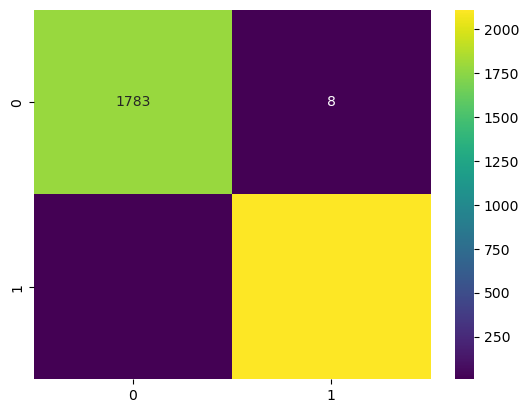

In [347]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "viridis", fmt = "d")

### XGBOOST
- Accuracy is 99%

In [348]:
# Column transformer
preprocessor = ColumnTransformer(
                                 transformers = [
                                                ("text", CountVectorizer(), "combined_text")]) # text vectorization

In [352]:
# Pipeline with model
model = Pipeline([
                    ("preprocess", preprocessor),
                    ("classifier", XGBClassifier())
])

In [353]:
# Train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text', CountVectorizer(),
                                                  'combined_text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, fea...ne,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [355]:
# Evaluate
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9964185213609619


## We will choose the simplest, fastest, and most interpretable model → Logistic Regression

- Works well for text classification.
- Easy to explain feature importance.
- Faster to train and deploy.

In [372]:
# Save the pipeline/model
joblib.dump(model, "misinformation_model.pkl")

# # Load later
# model_loaded = joblib.load("misinformation_model.pkl")

# # Test
# print(model_loaded.predict([["Some example text"]]))

['misinformation_model.pkl']